## Regression Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

### Dataset
In this homework, we will use the Laptops price dataset from Kaggle.
Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv):

In [88]:
import pandas as pd
import numpy as np
import wget

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [89]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
file = wget.download(url)
data = pd.read_csv(file, delimiter=',', header='infer')
data.head()

100% [............................................................................] 298573 / 298573

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


**The goal of this homework is to create a regression model for predicting the prices (column 'Final Price').**

### Preparing the dataset

We normalize the columns names:

In [90]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

We only use the following required columns for the following sections:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [91]:
df = data[['ram','storage','screen','final_price']]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


### EDA
We check the variable `final_price`

<Axes: xlabel='final_price', ylabel='Count'>

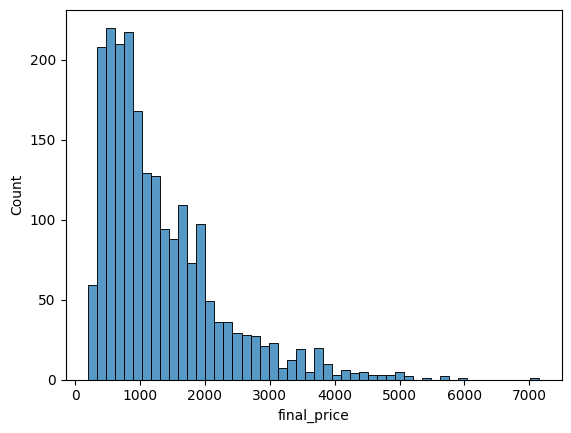

In [92]:
sns.histplot(df.final_price, bins = 50)

> Note that `final_price` is skewed to the right so we should log it

### Q1. What columns have missing values?

In [93]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Q2. What is the median (50% percentile) for variable `ram` ?

In [94]:
df['ram'].describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

### Prepare and split the dataset
* Shuffle df, not data, using seed `42`
* Split your data in your train/val/test sets with 60/20/20 distribution

Use the same code as in the lectures

In [95]:
# The number of records/observations
n = len(df)

# Indexing and shuffling
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)


# different splits index
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test


## Building the sets:
# - Train: from 0 to 1296(excl)
# - val: from 1296 to 1296+432 = 1728(excl)
# - test: from 1728 till the end

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

## Target variable
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

# log y values
y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

## Update the split sets
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [96]:
print(idx)
n, n_train, n_val, n_test

[2079  668 2073 ... 1130 1294  860]


(2160, 1296, 432, 432)

In [97]:
df_train.head()

,ram,storage,screen
2079,32,1000,15.6
668,4,64,14.1
2073,32,1000,14.0
1113,16,512,13.3
788,32,1000,16.0


In [98]:
df_val.head()

,ram,storage,screen
132,32,1000,16.0
80,16,512,15.6
1706,12,512,15.6
1769,8,256,13.6
541,8,512,15.6


In [99]:
df_test.head()

,ram,storage,screen
1925,32,1000,15.6
612,16,512,13.0
443,16,512,15.6
1002,16,512,15.0
1077,16,1000,15.6


### Q3. Fill in NA and train the model without regularization

In [100]:
# Define our linear model
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Define our rmse
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)


### ---- Fill in Options
## Option 1. O
def prepare_zero(df):
    df = df.fillna(0)
    X = df.values
    return X

## Option 2. mean
def prepare_mean(df):
    df = df.fillna(df_train.mean())
    X = df.values
    return X


In [101]:
# Fill in df_train

## df_val with 0 and val
w_0_zero, w_zero = train_linear_regression(X_train_zero, y_train)
X_val_zero = prepare_zero(df_val)
y_pred_zero = w_0_zero + X_val_zero.dot(w_zero)

## df_val with mean and val
w_0_mean, w_mean = train_linear_regression(X_train_zero, y_train)
X_val_mean = prepare_mean(df_val)
y_pred_mean = w_0_mean + X_val_mean.dot(w_mean)

In [102]:
# Evaluation with training set
error_zero = round(rmse(y_val, y_pred_zero), 2)
error_mean = round(rmse(y_val, y_pred_mean), 2)

# Evaluation with validation set
print('RMSE errors on validation set with different imputing methods:')
print(f" - RMSE after filling NA with 0 is {error_zero}.")
print(f" - RMSE after filling NA with 0 is {error_mean}.")

RMSE errors on validation set with different imputing methods:
 - RMSE after filling NA with 0 is 0.43.
 - RMSE after filling NA with 0 is 0.43.


### Q4. Train using a regularized regression

In [103]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

We use the training set filled with zero for NA created above

In [104]:
# We use the X_val_zero which is the val set found after filling with 0

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0_reg, w_reg = train_linear_regression_reg(X_train_zero, y_train, r=r)
    y_pred_reg = w_0_reg + X_val_zero.dot(w_reg)
    print('%6s' %r, round(rmse(y_val, y_pred_reg),2))

     0 0.43
  0.01 0.43
   0.1 0.43
     1 0.43
     5 0.46
    10 0.51
   100 0.67


### Q5. Different seeds

In [105]:
seeds = range(10)  # Seed values from 0 to 9
rmse_scores = []

for seed in seeds:
    # Length of the DataFrame
    n = len(df)

    # Indexing and shuffling
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    # Different splits index
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    # Building the sets
    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    # Target variable
    y_train_orig = df_train['final_price'].values
    y_val_orig = df_val['final_price'].values
    y_test_orig = df_test['final_price'].values

    # Log y values
    y_train = y_train_orig
    y_val = y_val_orig
    y_test = y_test_orig

    # Update the split sets by removing 'final_price'
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    # Fill in with 0
    X_train = prepare_zero(df_train)
    X_val = prepare_zero(df_val)
    X_test = prepare_zero(df_test)

    # train the model  
    w_0, w = train_linear_regression(X_train, y_train)
    
    # Evaluate each model on on the validation set
    y_pred = w_0 + X_val.dot(w)

    # Compute RMSE for each seed
    validation_rmse = rmse(y_val, y_pred)

    # Append all the RMSE scores
    rmse_scores.append(validation_rmse)
    
    # Print the seed value and RMSE for the validation set
    print(f"Seed: {seed} | Validation RMSE: {validation_rmse:.4f}")
    

Seed: 0 | Validation RMSE: 565.4521
Seed: 1 | Validation RMSE: 636.7985
Seed: 2 | Validation RMSE: 588.9559
Seed: 3 | Validation RMSE: 597.8149
Seed: 4 | Validation RMSE: 571.9628
Seed: 5 | Validation RMSE: 573.2383
Seed: 6 | Validation RMSE: 647.3438
Seed: 7 | Validation RMSE: 550.4398
Seed: 8 | Validation RMSE: 587.3335
Seed: 9 | Validation RMSE: 576.1018


Let us compute the standard deviation of all the RMSE

In [106]:
rmse_std = round(np.std(rmse_scores), 3)
print(f"Standard Deviation of RMSE Scores: {rmse_std:.4f}")

Standard Deviation of RMSE Scores: 29.1760


> Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

### Q6. Train using seed=9, train + val, NA filled with 0, and r = 0.001

In [107]:
n = len(df)

# Indexing and shuffling
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

# Different splits index
n_test = int(n * 0.2)
n_train_val = n - n_test

# Building the sets
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train_val].copy()
df_test = df_shuffled.iloc[n_train_val:].copy()

# Target variable
y_train_orig = df_train['final_price'].values
y_test_orig = df_test['final_price'].values

# Log y values
y_train = y_train_orig
y_test = y_test_orig

# Update the split sets by removing 'final_price'
del df_train['final_price']
del df_test['final_price']

# Fill in with 0
X_train = prepare_zero(df_train)
X_test = prepare_zero(df_test)

# train the model & Evaluate on testing set
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_test.dot(w)
print('RMSE errors on testing set using 0 as imputation method: ', round(rmse(y_test, y_pred),2))

RMSE errors on testing set using 0 as imputation method:  608.61


Voilà

See you next time for more fun 🖖